In [74]:
import pandas as pd
import json
from environs import Env
from neo4j import GraphDatabase

env = Env()
env.read_env()

EPIGRAPHDB_SERVER = env.str("EPIGRAPHDB_SERVER")
EPIGRAPHDB_USER = "neo4j"
EPIGRAPHDB_PORT = env.str("EPIGRAPHDB_PORT")
EPIGRAPHDB_PASSWORD = env.str("EPIGRAPHDB_PASSWORD")
print(EPIGRAPHDB_PORT)

epigraphdb_driver = GraphDatabase.driver(
    "bolt://{server_name}:{port}".format(
        server_name=EPIGRAPHDB_SERVER, port=EPIGRAPHDB_PORT),
    auth=(EPIGRAPHDB_USER, EPIGRAPHDB_PASSWORD))

session = epigraphdb_driver.session()

def query_to_df(query):
    print(query)
    data=session.run(query).data()
    df = pd.json_normalize(data)
    return(df)

37687


# Looking at literature connections

In [13]:
# get all types of predicate
query="""
MATCH (gwas:Gwas)-[gs:GWAS_TO_LITERATURE_TRIPLE]->(triple:LiteratureTriple) -[sl:SEMMEDDB_TO_LIT]->(lit:Literature) 
return distinct triple.predicate limit 43
"""
#df = query_to_df(query)
#df

### Example query "GWAS - literature - GWAS"

In [4]:
# Childhood obesity -> breast cancer

query="""
MATCH (gwas:Gwas)-[gwas_to_lit1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) 
-[:SEMMEDDB_OBJ]->(lit_term:LiteratureTerm)<-[:SEMMEDDB_SUB]- (s2:LiteratureTriple)<-[gwas_to_lit2:GWAS_TO_LITERATURE_TRIPLE]-(assoc_gwas:Gwas) 
WHERE gwas.id = "ieu-a-1096" AND assoc_gwas.id = "ieu-a-1126" 
AND gwas_to_lit1.pval < 1e-05 AND gwas_to_lit2.pval < 1e-05 
AND NOT lit_term.type IN ['nusq','dsyn'] 
RETURN distinct gwas.id, gwas.trait, gwas_to_lit1.pval,  s1.predicate, lit_term.name, s2.predicate, gwas_to_lit2.pval, assoc_gwas.id, assoc_gwas.trait 
order by gwas_to_lit2.pval
SKIP 0 LIMIT 1000
"""
df_obesity_lit = query_to_df(query)
df_obesity_lit



MATCH (gwas:Gwas)-[gwas_to_lit1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) 
-[:SEMMEDDB_OBJ]->(lit_term:LiteratureTerm)<-[:SEMMEDDB_SUB]- (s2:LiteratureTriple)<-[gwas_to_lit2:GWAS_TO_LITERATURE_TRIPLE]-(assoc_gwas:Gwas) 
WHERE gwas.id = "ieu-a-1096" AND assoc_gwas.id = "ieu-a-1126" 
AND gwas_to_lit1.pval < 1e-05 AND gwas_to_lit2.pval < 1e-05 
AND NOT lit_term.type IN ['nusq','dsyn'] 
RETURN distinct gwas.id, gwas.trait, gwas_to_lit1.pval,  s1.predicate, lit_term.name, s2.predicate, gwas_to_lit2.pval, assoc_gwas.id, assoc_gwas.trait 
order by gwas_to_lit2.pval
SKIP 0 LIMIT 1000



,gwas.id,gwas.trait,gwas_to_lit1.pval,s1.predicate,lit_term.name,s2.predicate,gwas_to_lit2.pval,assoc_gwas.id,assoc_gwas.trait
0,ieu-a-1096,Childhood obesity,8.204412e-06,INHIBITS,H3F3AP6,STIMULATES,2.287763e-14,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
1,ieu-a-1096,Childhood obesity,8.204412e-06,INHIBITS,NSG1,STIMULATES,2.287763e-14,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
2,ieu-a-1096,Childhood obesity,8.204412e-06,INHIBITS,TCEAL1,STIMULATES,2.287763e-14,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
3,ieu-a-1096,Childhood obesity,8.204412e-06,INHIBITS,CDKN1A,STIMULATES,2.287763e-14,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
4,ieu-a-1096,Childhood obesity,8.204412e-06,ASSOCIATED_WITH,Obesity,PREDISPOSES,1.804619e-12,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
...,...,...,...,...,...,...,...,...,...
506,ieu-a-1096,Childhood obesity,4.543086e-07,COEXISTS_WITH,leptin,STIMULATES,5.440435e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
507,ieu-a-1096,Childhood obesity,8.847083e-13,COEXISTS_WITH,Insulin,STIMULATES,5.440435e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
508,ieu-a-1096,Childhood obesity,8.204412e-06,COEXISTS_WITH,testosterone,INTERACTS_WITH,9.004132e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
509,ieu-a-1096,Childhood obesity,8.204412e-06,COEXISTS_WITH,testosterone,INTERACTS_WITH,9.548222e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...


## Testing literature triples


In [17]:
genes_test_df = pd.read_csv("query_results/bc_gwas_expressed_in_breastTissue.tsv", sep = '\t')
GENE_LIST = list(set(genes_test_df['gene.name']))
len(GENE_LIST) # genes expressed in breast tissues with effect in GWAS

98

In [22]:
# tophits in GWAS -> genes -> expressed in Breast tissue -> map to lit -> triple to other lit term
query = """
        MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt:LiteratureTriple)-[]-(l2:LiteratureTerm)
        WHERE g.name in {gene_list}
        WITH  g,lt,l1,l2
        MATCH (lt)-[]-(lit:Literature) 
        RETURN l1.name as gene_as_litterm, lt.predicate as pred, l2.name as obj_as_litterm,
        l2.type as obj_as_littermType,  collect (lit.id) as  lit_ids;
    """.format(gene_list=GENE_LIST)
df= query_to_df(query)
df


        MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt:LiteratureTriple)-[]-(l2:LiteratureTerm)
        WHERE g.name in ['NEK10', 'ANKLE1', 'ABO', 'ATG10', 'ADCY3', 'CREB5', 'CHEK2', 'ZNF184', 'HSCB', 'HSPA4', 'KANSL1', 'ELL', 'TET2', 'CBX8', 'MCM8', 'SETBP1', 'SSBP4', 'MKL1', 'PHLDA3', 'EBF1', 'TLR1', 'MLLT10', 'TTC28', 'LGR6', 'PEX14', 'FTO', 'SUB1', 'KCNN4', 'RIN3', 'OR2A1-AS1', 'SF3B4', 'N4BP2L1', 'TRIM46', 'CCDC88C', 'ADCY9', 'LINC-PINT', 'SLC25A22', 'USHBP1', 'ADSSL1', 'TCF7L2', 'VGLL3', 'STXBP4', 'FAM46A', 'MTMR11', 'CDYL2', 'MDM4', 'ASTN2', 'MYEOV', 'ATXN7', 'RANBP9', 'ESR1', 'GRHL1', 'L3MBTL3', 'CDCA7L', 'PLA2G6', 'ULK3', 'ARRDC3', 'AMFR', 'FGFR2', 'CUX1', 'OTUD7B', 'BABAM1', 'KRTCAP2', 'FAM175A', 'NREP', 'CASP8', 'PIDD', 'ZMIZ1', 'SCAMP2', 'GIPR', 'ARHGEF5', 'ZBTB38', 'PIK3R3', 'PDE4D', 'CMSS1', 'RPL23AP53', 'MAGI3', 'LSP1', 'ATAD5', 'ZFPM2', 'SV2A', 'DNAJC1', 'RCCD1', 'TGFBR2', 'PRC1', 'NRIP1', 'TACC2', 'ITPR1', 'GAREM', 'LMX1B', 'RNF115', 'FOXP1', 'FILIP1L', 'V

,gene_as_litterm,pred,obj_as_litterm,obj_as_littermType,lit_ids
0,NRIP1,AFFECTS,Obesity,[dsyn],"[20205832, 20680503]"
1,NRIP1,INHIBITS,HOXA5,"[gngm, aapp]",[19862326]
2,NRIP1,COEXISTS_WITH,Tretinoin,"[phsu, orch, hops]",[19862326]
3,NRIP1,STIMULATES,"Receptors, Nuclear","[gngm, aapp]","[19862326, 19862326]"
4,NRIP1,INHIBITS,ERN1,"[gngm, aapp]",[28222026]
...,...,...,...,...,...
23594,TGFBR2,COEXISTS_WITH,connective tissue growth factor,"[gngm, aapp]",[23816882]
23595,TGFBR2,COEXISTS_WITH,NFIC,"[gngm, aapp]",[23933490]
23596,TGFBR2,INHIBITS,methamphetamine,"[phsu, orch, hops]",[17669262]
23597,TGFBR2,INTERACTS_WITH,CCAAT-Enhancer-Binding Protein-alpha,"[gngm, aapp]",[24284203]


In [19]:
len(set(df['gene_as_litterm']))

87

In [23]:
df[df['gene_as_litterm'] == 'ESR1']

,gene_as_litterm,pred,obj_as_litterm,obj_as_littermType,lit_ids
18762,ESR1,NEG_INTERACTS_WITH,Genes,"[gngm, aapp]",[31514021]
18763,ESR1,STIMULATES,ESR2 gene,"[gngm, aapp]","[31514021, 31514021]"
18764,ESR1,INHIBITS,RNA Polymerase II,"[gngm, aapp]",[31504407]
18765,ESR1,INHIBITS,Cadherins,"[gngm, aapp]",[30604272]
18766,ESR1,PREDISPOSES,Osteoporosis,[dsyn],[31450614]
...,...,...,...,...,...
22280,ESR1,INTERACTS_WITH,reproductive hormone,[horm],"[30058584, 24045481]"
22281,ESR1,INTERACTS_WITH,Chlorotoxin,[aapp],[30806044]
22282,ESR1,COEXISTS_WITH,ROS1,"[gngm, aapp]",[25338520]
22283,ESR1,INHIBITS,MIR21,"[gngm, aapp]",[31354287]


In [39]:
#GENE_LIST = ['ATG10']

# Do not run full - too long

GENE_LIST = genes_test
query = """
        MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)
        WHERE g.name in {gene_list}
        WITH  g,l1,lt1, l2, lt2, l3
        MATCH (lt1)-[]-(lit:Literature) 
        RETURN l1.name as term1, lt1.predicate as pred1, l2.name as term2 ,  lt2.predicate as pred2, l3.name as term3 , lit.id

    """.format(gene_list=GENE_LIST)
#df= query_to_df(query)
#df

In [11]:
gene_list = genes_test 

# tophits in GWAS -> genes -> expressed in Breast tissue -> map to lit -> other term -> predicate to a disease
# where middle term contains 'breast'
query="""
MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
WHERE g.name in {} 
AND toLower(l2.name) contains 'breast'
WITH  g,l1,lt1, l2, lt2, l3, d
MATCH (lt1)-[]-(lit1:Literature) 
MATCH (lt2)-[]-(lit2:Literature) 
RETURN l1.name as term1, lt1.predicate as pred1,
        l2.name as term2 ,  lt2.predicate as pred2,
        l3.name as term3 , d.label as Disease,
        lit1.id, lit2.id
""".format(gene_list)

df= query_to_df(query)
df


MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
WHERE g.name in ['NEK10', 'ANKLE1', 'ABO', 'ATG10', 'ADCY3', 'CREB5', 'CHEK2', 'ZNF184', 'HSCB', 'HSPA4', 'KANSL1', 'ELL', 'TET2', 'CBX8', 'MCM8', 'SETBP1', 'SSBP4', 'MKL1', 'PHLDA3', 'EBF1', 'TLR1', 'MLLT10', 'TTC28', 'LGR6', 'PEX14', 'FTO', 'SUB1', 'KCNN4', 'RIN3', 'OR2A1-AS1', 'SF3B4', 'N4BP2L1', 'TRIM46', 'CCDC88C', 'ADCY9', 'LINC-PINT', 'SLC25A22', 'USHBP1', 'ADSSL1', 'TCF7L2', 'VGLL3', 'STXBP4', 'FAM46A', 'MTMR11', 'CDYL2', 'MDM4', 'ASTN2', 'MYEOV', 'ATXN7', 'RANBP9', 'ESR1', 'GRHL1', 'L3MBTL3', 'CDCA7L', 'PLA2G6', 'ULK3', 'ARRDC3', 'AMFR', 'FGFR2', 'CUX1', 'OTUD7B', 'BABAM1', 'KRTCAP2', 'FAM175A', 'NREP', 'CASP8', 'PIDD', 'ZMIZ1', 'SCAMP2', 'GIPR', 'ARHGEF5', 'ZBTB38', 'PIK3R3', 'PDE4D', 'CMSS1', 'RPL23AP53', 'MAGI3', 'LSP1', 'ATAD5', 'ZFPM2', 'SV2A', 'DNAJC1', 'RCCD1', 'TGFBR2', 'PRC1', 'NRIP1', 'TAC

,term1,pred1,term2,pred2,term3,Disease,lit1.id,lit2.id
0,ESR1,ASSOCIATED_WITH,"Breast Fibrocystic Change, Proliferative Type",COEXISTS_WITH,Breast Diseases,breast disease,16327431,17417639
1,ESR1,ASSOCIATED_WITH,"Breast Fibrocystic Change, Proliferative Type",AFFECTS,Breast Diseases,breast disease,16327431,11289127
2,ARHGEF5,AFFECTS,"Breast Fibrocystic Change, Proliferative Type",COEXISTS_WITH,Breast Diseases,breast disease,14662653,17417639
3,ARHGEF5,AFFECTS,"Breast Fibrocystic Change, Proliferative Type",AFFECTS,Breast Diseases,breast disease,14662653,11289127


In [17]:
# extarct sentences where those lit predicates come from:
def get_sentence_data(pmid):
    url = "https://melodi-presto.mrcieu.ac.uk/api/sentence/"
    params = { "pmid": pmid,}
    response = requests.post(url, data=json.dumps(params))
    res = response.json()
    df = pd.json_normalize(res)
    return df

sentence_data = get_sentence_data("17417639")
for ss in sentence_data["data"]:
    for s in ss:
        print(s["SUB_PRED_OBJ"])
        print("SENTENCE:", s["SENTENCE"])
        print("\n")

NameError: name 'requests' is not defined

In [18]:
sentence_data = get_sentence_data("11289127")
for ss in sentence_data["data"]:
    for s in ss:
        print(s["SUB_PRED_OBJ"])
        print("SENTENCE:", s["SENTENCE"])
        print("\n")
        

NameError: name 'requests' is not defined

In [ ]:
bc_all_gwas_to_path[bc_all_gwas_to_path['gene.name']=='ESR1']

In [ ]:
bc_er_pos_gwas_to_path[bc_er_pos_gwas_to_path['gene.name']=='ESR1']

In [ ]:
bc_er_neg_gwas_to_path[bc_er_neg_gwas_to_path['gene.name']=='ESR1']

In [ ]:
list(bc_er_pos_gwas_to_path[bc_er_pos_gwas_to_path['gene.name']=='ESR1']['Pathways'])

In [19]:
gene_list = genes_test 

# tophits in GWAS -> genes -> expressed in Breast tissue -> map to lit -> other term -> predicate to a disease
# where third term contains 'breast'
query="""
MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
WHERE g.name in {} 
AND toLower(l3.name) contains 'breast'
WITH  g,l1,lt1, l2, lt2, l3, d
MATCH (lt1)-[]-(lit1:Literature) 
MATCH (lt2)-[]-(lit2:Literature) 
RETURN l1.name as term1, lt1.predicate as pred1,
        l2.name as term2 ,  lt2.predicate as pred2,
        l3.name as term3 , d.label as Disease,
        lit1.id, lit2.id
""".format(gene_list)

df= query_to_df(query)
df
#df=df[df["term2"]!= "Genes"]
#df.sort_values(by=['Disease'])
#df[df["pred1"] not in ["COEXISTS_WITH"]]

NameError: name 'genes_test' is not defined

## Mapping enterobiasis drugs to true diseases via literature

In [62]:
enterobiasis_drugs_df = pd.read_csv("query_results/enterobiasis_drugs.tsv", sep = '\t')
enterobiasis_drugs = list(set(enterobiasis_drugs_df['drug.label']))

In [79]:
# checking one DRUG
query = """
MATCH (drug:Drug)-[OPENTARGETS_DRUG_TO_TARGET]->(g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
        where drug.label = 'ABEMACICLIB'
        WITH  drug, l1,lt1, l2, lt2, l3, d
        where tolower(d.label) contains 'breast'
        and not any(types in ['dsyn'] WHERE types IN l2.type)
        and not any(term in ['Genes', 'Proteins', 'Hormones', 'Receptors', 'Tumor Suppressor Genes'] WHERE term IN l2.name)
        RETURN drug.label as DRUG, 
                l1.name as term1_drugTarget, lt1.predicate as pred1,
                l2.name as term2 , l2.type as term2_type , lt2.predicate as pred2,
                l3.name as term3
    """
#.format(gene_list=GENE_LIST)
df= query_to_df(query)
df


MATCH (drug:Drug)-[OPENTARGETS_DRUG_TO_TARGET]->(g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
        where drug.label = 'ABEMACICLIB'
        WITH  drug, l1,lt1, l2, lt2, l3, d
        where tolower(d.label) contains 'breast'
        and not any(types in ['dsyn'] WHERE types IN l2.type)
        and not any(term in ['Genes', 'Proteins', 'Hormones', 'Receptors', 'Tumor Suppressor Genes'] WHERE term IN l2.name)
        RETURN drug.label as DRUG, 
                l1.name as term1_drugTarget, lt1.predicate as pred1,
                l2.name as term2 , l2.type as term2_type , lt2.predicate as pred2,
                l3.name as term3
    


,DRUG,term1_drugTarget,pred1,term2,term2_type,pred2,term3
0,ABEMACICLIB,CDK6,INHIBITS,"TNF protein, human","[gngm, aapp]",ASSOCIATED_WITH,Breast Fibrocystic Disease
1,ABEMACICLIB,CDK4,INTERACTS_WITH,"TNF protein, human","[gngm, aapp]",ASSOCIATED_WITH,Breast Fibrocystic Disease
2,ABEMACICLIB,CDK4,STIMULATES,"TNF protein, human","[gngm, aapp]",ASSOCIATED_WITH,Breast Fibrocystic Disease
3,ABEMACICLIB,CDK4,NEG_INTERACTS_WITH,"TNF protein, human","[gngm, aapp]",ASSOCIATED_WITH,Breast Fibrocystic Disease
4,ABEMACICLIB,CDK6,INHIBITS,TNF,"[phsu, gngm, aapp]",ASSOCIATED_WITH,Breast Fibrocystic Disease
...,...,...,...,...,...,...,...
431,ABEMACICLIB,CDK4,PRODUCES,LMOD1,"[phsu, gngm, aapp]",ASSOCIATED_WITH,Breast Diseases
432,ABEMACICLIB,CDK4,STIMULATES,LMOD1,"[phsu, gngm, aapp]",ASSOCIATED_WITH,Breast Diseases
433,ABEMACICLIB,CDK4,INTERACTS_WITH,LMOD1,"[phsu, gngm, aapp]",ASSOCIATED_WITH,Breast Diseases
434,ABEMACICLIB,CDK6,INHIBITS,"TFF1 protein, human","[gngm, aapp]",ASSOCIATED_WITH,Breast Diseases


In [78]:
set(df['term3'])

{'Breast Diseases', 'Breast Fibrocystic Disease', 'Fibrosclerosis of breast'}

In [77]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt


# create network data
d = []
d = df[["DRUG", "term1_drugTarget"]].values.tolist()
#d = d + df[["term3", "term3"]].values.tolist()
d = d + df[["term1_drugTarget", "term2"]].values.tolist()
d = d + df[["term2", "term3"]].values.tolist()


def add_newlines(text):
    text = text.replace(" ", "\n")
    return text


# add newlines to text to make them fit in the nodes! Got to be a better way to do this....
d_edit = []
for i in d:
    d_edit.append([add_newlines(x) for x in i])


# create the edge labels
labels = {}
for l in df[
    ["term1_drugTarget", "term2", "pred1"]].drop_duplicates().values.tolist():
    labels[(add_newlines(l[0]), add_newlines(l[1]))] = (add_newlines(l[2]))
    
for l in df[
    ["term2", "term3", "pred2"]].drop_duplicates().values.tolist():
    labels[(add_newlines(l[0]), add_newlines(l[1]))] = (
        add_newlines(l[2]))


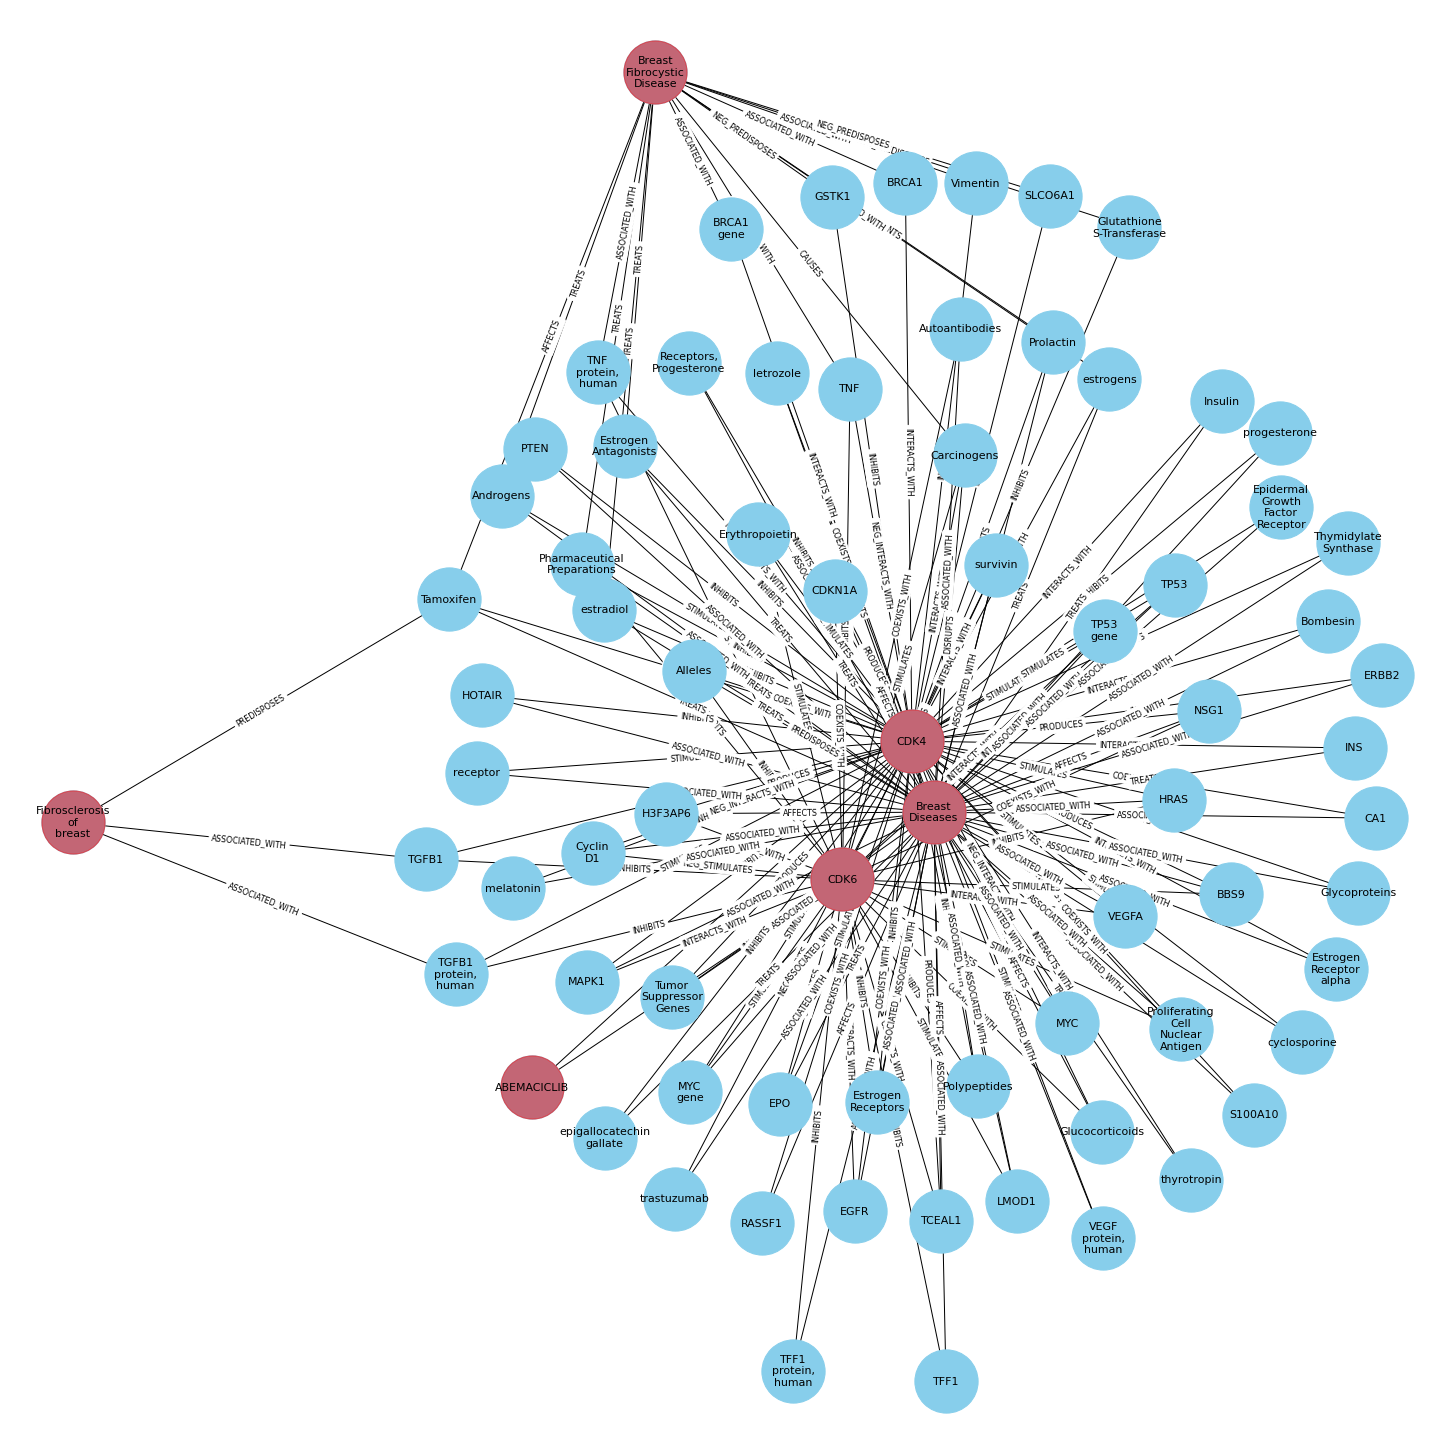

In [87]:
# create the network
plt.figure(figsize=(20, 20))

G = nx.Graph(d_edit)

pos = graphviz_layout(G)

node_size = 4000

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_size,
    node_color="skyblue",
    font_size=11,
)

nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)


# colour the GWAS nodes
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=['ABEMACICLIB' , 'CDK4', 'CDK6', 
              'Breast\nDiseases', 'Breast\nFibrocystic\nDisease', 'Fibrosclerosis\nof\nbreast'],
    node_color="r",
    node_size=node_size,
    alpha=0.5,
)
plt.show()
#plt.savefig("figures/TEST.png")